In [ ]:
import numpy as np

class GnosticRobustRegression:
    """
    A class to perform Gnostic Robust Regression based on the iterative formula
    described in Equation 19.2 of the provided reference.
    """

    def __init__(self, X, y, criterion="E1", max_iter=100, tol=1e-6, scale_param=1.0):
        """
        Initialize the regression model.

        Parameters:
        - X: np.ndarray, shape (n_samples, n_features)
            The input feature matrix.
        - y: np.ndarray, shape (n_samples,)
            The target vector.
        - criterion: str
            The gnostic criterion to use (e.g., "Q1", "E1", "Q2", etc.).
        - max_iter: int
            Maximum number of iterations for the regression.
        - tol: float
            Tolerance for convergence.
        - scale_param: float
            The scale parameter S for gnostic calculations.
        """
        self.X = X
        self.y = y
        self.criterion = criterion
        self.max_iter = max_iter
        self.tol = tol
        self.scale_param = scale_param
        self.weights = np.ones(X.shape[0])  # Initialize weights to 1
        self.coefficients = None

    def _compute_q(self, residuals):
        """
        Compute the gnostic parameter q based on residuals and the scale parameter.

        Parameters:
        - residuals: np.ndarray, shape (n_samples,)
            The residuals of the current iteration.

        Returns:
        - q: np.ndarray, shape (n_samples,)
            The gnostic parameter q.
        """
        Z = self.y
        Z0 = self.z0 # Use the median as a robust estimate of Z0
        q = (Z / Z0) ** (2 / self.scale_param)
        return q

    def _compute_filtering_weight(self, residuals):
        """
        Compute the filtering weights based on the selected gnostic criterion.

        Parameters:
        - residuals: np.ndarray, shape (n_samples,)
            The residuals of the current iteration.

        Returns:
        - weights: np.ndarray, shape (n_samples,)
            The updated filtering weights.
        """
        q = self._compute_q(residuals)
        q1 = 1 / q

        if self.criterion == "Q1":
            h_q = (q - q1) / (q + q1)
            f_q = 1 / (h_q + 1e-8)  # Avoid division by zero
            return f_q
        elif self.criterion == "E1":
            h_e = (q - q1) / 2
            f_e = 1 / (h_e + 1e-8)
            return f_e ** 2
        elif self.criterion == "Q2":
            return np.ones_like(residuals)  # Constant weight for Q2
        elif self.criterion == "E2":
            h_e = (q - q1) / 2
            f_e = 1 / (h_e + 1e-8)
            return f_e
        elif self.criterion == "Q3":
            h_q = (q - q1) / (q + q1)
            f_q = 1 / (h_q + 1e-8)
            return 1 / np.sqrt(f_q)
        elif self.criterion == "E3":
            h_e = (q - q1) / 2
            f_e = 1 / (h_e + 1e-8)
            return np.sqrt(f_e)
        else:
            raise ValueError(f"Unknown criterion: {self.criterion}")

    def _update_weights(self, residuals):
        """
        Update the weights based on the residuals and the filtering function.

        Parameters:
        - residuals: np.ndarray, shape (n_samples,)
            The residuals of the current iteration.
        """
        self.weights = self._compute_filtering_weight(residuals)

    def fit(self):
        """
        Fit the regression model using the iterative weighted least squares approach.
        """
        n_samples, n_features = self.X.shape
        X_weighted = self.X.copy()
        y_weighted = self.y.copy()

        # Initialize coefficients
        self.coefficients = np.zeros(n_features)

        for iteration in range(self.max_iter):
            # Compute residuals
            self.z0 = np.dot(self.X, self.coefficients)
            residuals = self.y - self.z0
            # Update weights
            self._update_weights(residuals)

            # Apply weights to the design matrix and target vector
            W = np.sqrt(self.weights)[:, np.newaxis]
            X_weighted = W * self.X
            y_weighted = W.flatten() * self.y

            # Solve the weighted least squares problem
            new_coefficients = np.linalg.lstsq(X_weighted, y_weighted, rcond=None)[0]

            # Check for convergence
            if np.linalg.norm(new_coefficients - self.coefficients) < self.tol:
                print(f"Converged in {iteration + 1} iterations.")
                break

            self.coefficients = new_coefficients
        else:
            print("Maximum iterations reached without convergence.")

    def predict(self, X):
        """
        Predict target values for the given input data.

        Parameters:
        - X: np.ndarray, shape (n_samples, n_features)
            The input feature matrix.

        Returns:
        - y_pred: np.ndarray, shape (n_samples,)
            The predicted target values.
        """
        return np.dot(X, self.coefficients)

    def get_weights(self):
        """
        Get the final weights after fitting the model.

        Returns:
        - weights: np.ndarray, shape (n_samples,)
            The final weights.
        """
        return self.weights

    def get_coefficients(self):
        """
        Get the fitted coefficients of the model.

        Returns:
        - coefficients: np.ndarray, shape (n_features,)
            The fitted coefficients.
        """
        return self.coefficients

Maximum iterations reached without convergence.


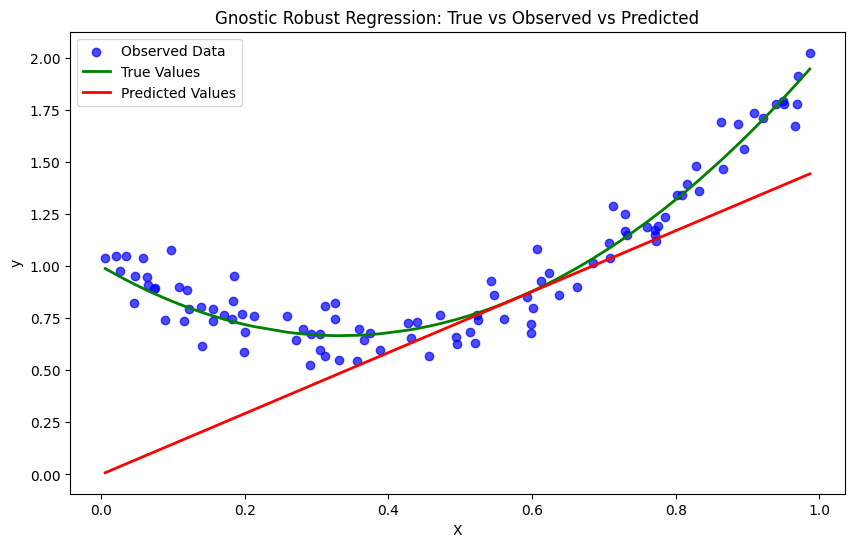

In [4]:
import numpy as np
import matplotlib.pyplot as plt

# Generate synthetic data
np.random.seed(42)
X = np.random.rand(100, 1)  # Single feature
y_true = 3 * X[:, 0]**2 - 2 * X[:, 0] + 1  # True quadratic function
y_observed = y_true + np.random.normal(0, 0.1, size=100)  # Add noise to create observed data

# Initialize and fit the model with degree 2 (quadratic regression)
model = GnosticRobustRegression(X, y_observed, criterion="E1", max_iter=100, tol=1e-6, scale_param=1.0)
model.fit()

# Predict values
y_pred = model.predict(X)

# Sort the data by X values for proper line plotting
sorted_indices = np.argsort(X[:, 0])  # Sort by the first column of X
X_sorted = X[sorted_indices]
y_true_sorted = y_true[sorted_indices]
y_pred_sorted = y_pred[sorted_indices]

# Plotting
plt.figure(figsize=(10, 6))

# Scatter plot of observed data
plt.scatter(X, y_observed, label="Observed Data", color="blue", alpha=0.7)

# Plot true values (sorted)
plt.plot(X_sorted, y_true_sorted, label="True Values", color="green", linewidth=2)

# Plot predicted values (sorted)
plt.plot(X_sorted, y_pred_sorted, label="Predicted Values", color="red", linewidth=2)

# Add labels, title, and legend
plt.title("Gnostic Robust Regression: True vs Observed vs Predicted")
plt.xlabel("X")
plt.ylabel("y")
plt.legend()

# Show the plot
plt.show()